# CAM and Object Detection (modified)

## Authors: 
Sat Arora \
Richard Fan

### Project Goal:
"CAM and object detection". First, you should implement some standard method for CAM for some (simple) classification network trained on image-level tags. You should also obtain object detection (spacial localization of the object approximate "center"). You should apply your approach to one specific object type (e.g. faces, or anything else). Training should be done on image-level tags (e.g. face, no face). You can come up with your specialized dataset, but feel free to use subsets of standard data. You can also test the ideas on real datasets where label noise is presemt

In [1]:
import torch
import torchvision.models as models
import cv2
import numpy as np
from torchvision import transforms
import torch.nn as nn


In [2]:
# # Pre-trained model used: ResNet 18
# model = models.resnet(pretrained=True)
# final_convolution_layer = 'layer4'
# model.eval()




In [3]:
# # img = cv2.imread('river_hand.jpeg')

# if img is not None:
#     print("Image loaded successfully!")
# else:
#     print("Unable to load the image. Please check the file path.")
    
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

# Load train and test datasets
train_dataset = ImageFolder('Dataset/train', transform=transform)
test_dataset = ImageFolder('Dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
import torchvision.models as models
import torch.nn as nn

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

# for param in model.fc.parameters():
#     param.requires_grad = True

# Modify the final fully connected layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 output classes: face and no-face

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/Users/fanrongqi/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/fanrongqi/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Training loop
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# for param in model.parameters():
#     param.requires_grad = False
    
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

/Users/fanrongqi/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5], Loss: 0.1274
Epoch [2/5], Loss: 0.0316
Epoch [3/5], Loss: 0.0664
Epoch [4/5], Loss: 0.0148
Epoch [5/5], Loss: 0.0183
Test Accuracy: 98.68%


In [12]:
model.eval()

# Remove the fully connected layer
model2 = nn.Sequential(*list(model.children())[:-2])
# model2 = model

Image loaded successfully!
(4032, 3024, 3)


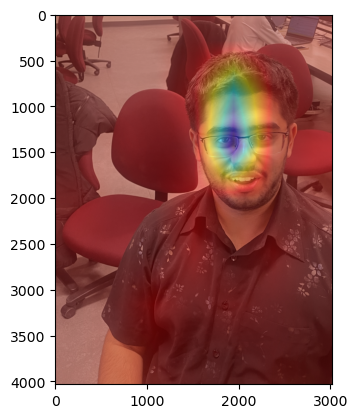

: 

In [22]:
# model.eval()

# # Remove the fully connected layer
# model = nn.Sequential(*list(model.children())[:-2])

# Load and preprocess the image
img = cv2.imread('sat.png')
# img = cv2.imread('river_hand.jpeg')

if img is not None:
    print("Image loaded successfully!")
else:
    print("Unable to load the image. Please check the file path.")


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_img = preprocess(img).unsqueeze(0).to(device)

# Forward pass to get feature maps
with torch.no_grad():
    feature_maps = model2(input_img)

# Get the weights of the final convolutional layer
final_conv_layer = None
for layer in reversed(model2):
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        final_conv_layer = layer
        break

if final_conv_layer is None:
    raise ValueError("Final convolutional layer not found in the model.")

final_conv_layer_weights = final_conv_layer.weight.detach().cpu()

# Compute the class activation map (CAM)
cam = np.zeros((feature_maps.shape[2], feature_maps.shape[3]), dtype=np.float32)
for i in range(final_conv_layer_weights.size(0)):
    weight = final_conv_layer_weights[i].detach().cpu().numpy()
    cam += np.sum(weight * feature_maps.squeeze(0)[i].cpu().numpy(), axis=0)

cam = np.maximum(cam, 0)  # ReLU activation
cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
cam = cam - np.min(cam)
cam = cam / np.max(cam)

# Apply heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
print(heatmap.shape)
superimposed_img = heatmap * 0.4 + img.astype('float32') * 0.6
superimposed_img = superimposed_img / superimposed_img.max()

# Display the original image and the image with the heatmap
cv2.imshow('Original Image', img)
cv2.imshow('CAM', np.uint8(255 * superimposed_img))
import matplotlib.pyplot as plt 
plt.imshow(img)
plt.imshow(np.uint8(255 * superimposed_img))
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [29]:
import torch
import torchvision.models as models
import cv2
import numpy as np
from torchvision import transforms
import torch.nn as nn

# Load pre-trained model
model = models.resnet50(pretrained=True)
model.eval()

# Remove the fully connected layer
model = nn.Sequential(*list(model.children())[:-2])

# Load and preprocess the image
img = cv2.imread('image_1.jpg')

if img is not None:
    print("Image loaded successfully!")
else:
    print("Unable to load the image. Please check the file path.")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_img = preprocess(img).unsqueeze(0)

# Forward pass to get feature maps
with torch.no_grad():
    feature_maps = model(input_img)

# Get the weights of the final convolutional layer
final_conv_layer = None
for layer in reversed(model):
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        final_conv_layer = layer
        break

if final_conv_layer is None:
    raise ValueError("Final convolutional layer not found in the model.")

final_conv_layer_weights = final_conv_layer.weight.detach().cpu()

# Compute the class activation map (CAM)
cam = np.zeros((feature_maps.shape[2], feature_maps.shape[3]), dtype=np.float32)
for i in range(final_conv_layer_weights.size(0)):
    weight = final_conv_layer_weights[i].detach().cpu().numpy()
    cam += np.sum(weight * feature_maps.squeeze(0)[i].cpu().numpy(), axis=0)

cam = np.maximum(cam, 0)  # ReLU activation
cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
cam = cam - np.min(cam)
cam = cam / np.max(cam)

# Apply heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
print(heatmap.shape)
superimposed_img = heatmap * 0.4 + img.astype('float32') * 0.6
superimposed_img = superimposed_img / superimposed_img.max()

# Display the original image and the image with the heatmap
cv2.imshow('Original Image', img)
cv2.imshow('CAM', np.uint8(255 * superimposed_img))
cv2.waitKey(0)
cv2.destroyAllWindows()


/Users/fanrongqi/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image loaded successfully!
(395, 640, 3)
